# Train RPN Network to segment


In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn.model_selection import train_test_split
import cv2
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import torch.nn.functional as F
import albumentations as A
import pandas as pd


# class CustomDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, transform=None):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = Image.open(self.image_paths[idx]).convert("L")
#         mask = Image.open(self.mask_paths[idx]).convert("L")

#         if self.transform:
#             image, mask = self.transform(image, mask)

#         return image, mask

c:\Users\DryLab\anaconda3\envs\ViLLA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        mask = Image.open(self.mask_paths[idx]).convert("L")
        mask = mask.resize((224, 224), Image.NEAREST)

        image = np.array(image)
        image = image.astype(np.float32) / 255.0  # Normalize image to [0, 1]
        mask = np.array(mask)
        mask = mask.astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0).long()

        return image, mask

In [5]:
# Define the transformation using albumentations
transform = A.Compose(
    [
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.5),
        A.Affine(scale=(0.9, 1.1), rotate=(-15, 15), shear=(-10, 10), p=0.5),
    ]
)

# val_transform = A.Compose([
#     ToTensorV2()
# ])

In [6]:
# transform = transforms.Compose(
#     [
#         transforms.RandomApply(
#             [
#                 transforms.ColorJitter(brightness=0.2, contrast=0.2),
#                 transforms.GaussianBlur(kernel_size=5),
#             ],
#             p=0.5,
#         ),
#         transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#         transforms.ToImage(),
#         transforms.ToDtype(torch.float32, scale=True),
#     ]
# )

# val_transform = transforms.Compose(
#     [
#         transforms.ToImage(),
#         transforms.ToDtype(torch.float32, scale=True),
#     ]
# )

In [7]:
image_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/preprocessed_xray"
mask_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/All247imagesPNG/masks"

# Get list of image and mask files
image_paths = sorted(
    [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
)
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Split data into train, validation, and test sets into 0.8, 0.1, 0.1
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = (
    train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_mask_paths, test_size=0.5, random_state=42
)

# Create dataset
train_heart_dataset = CustomDataset(
    train_image_paths, train_mask_paths, transform=transform
)
val_heart_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=None)
test_heart_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=None)

# Create dataloader
train_dataloader = DataLoader(train_heart_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_heart_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_heart_dataset, batch_size=16, shuffle=False)

In [8]:
image, mask = next(iter(train_dataloader))
image.shape, mask.shape

(torch.Size([16, 1, 224, 224]), torch.Size([16, 1, 224, 224]))

In [9]:
np.unique(image)

array([0.0000000e+00, 2.0204936e-08, 7.4439235e-08, ..., 9.9999982e-01,
       9.9999994e-01, 1.0000000e+00], dtype=float32)

In [10]:
np.unique(mask)

array([0, 1, 2, 3], dtype=int64)

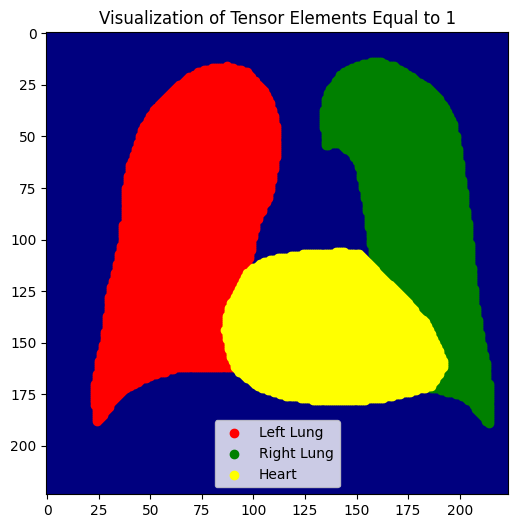

In [11]:
left_lung = np.column_stack(np.where(mask[0, 0] == 1))
right_lung = np.column_stack(np.where(mask[0, 0] == 2))
heart = np.column_stack(np.where(mask[0, 0] == 3))

plt.figure(figsize=(6, 6))
plt.imshow(mask[0, 0], cmap="jet", interpolation="none")
plt.scatter(
    left_lung[:, 1], left_lung[:, 0], color="red", marker="o", label="Left Lung"
)
plt.scatter(
    right_lung[:, 1], right_lung[:, 0], color="green", marker="o", label="Right Lung"
)
plt.scatter(heart[:, 1], heart[:, 0], color="yellow", marker="o", label="Heart")
plt.legend()
plt.title("Visualization of Tensor Elements Equal to 1")
plt.show()

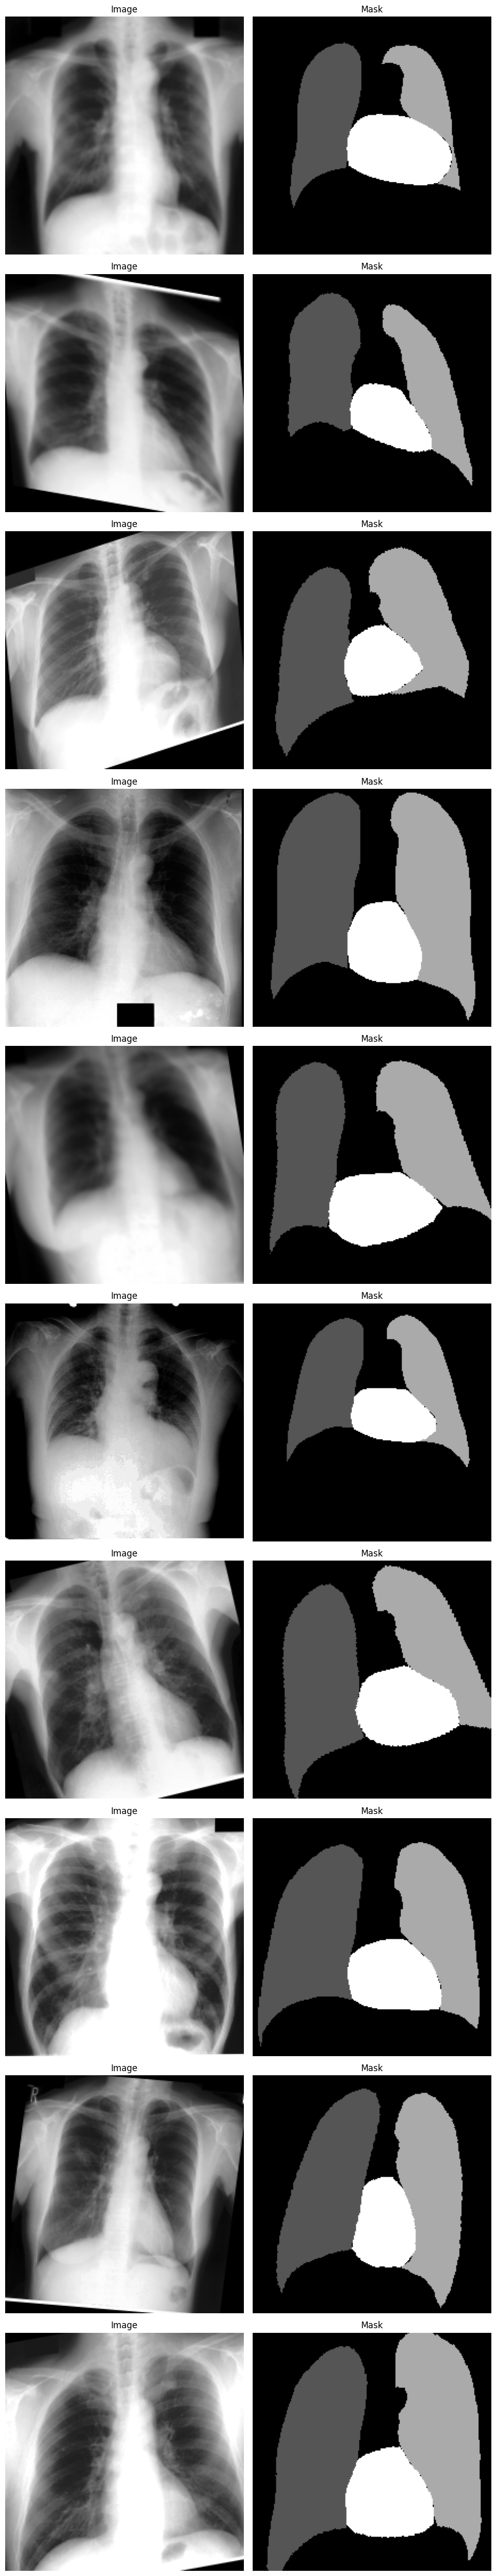

In [12]:
def visualize_sample(images, masks, n_samples=4):
    """
    Function to visualize a batch of images and masks.

    Parameters:
    images (torch.Tensor): Batch of images.
    masks (torch.Tensor): Batch of masks.
    n_samples (int): Number of samples to visualize.
    """
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, n_samples * 5))
    for i in range(n_samples):
        img = images[i].numpy()  # Convert from (C, H, W) to (H, W, C)
        mask = masks[i].numpy()  # Convert from (C, H, W) to (H, W, C)

        axes[i, 0].imshow(img.squeeze(), cmap="gray")  # Display the image
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask.squeeze(), cmap="gray")  # Display the mask
        axes[i, 1].set_title("Mask")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()


# Use the DataLoader to load a batch of images and masks
images, masks = next(iter(train_dataloader))

# Visualize the first few samples
visualize_sample(images, masks, n_samples=10)

# Model Initialization


In [13]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation="sigmoid",
)

In [14]:
preprocessing_fn = smp.encoders.get_preprocessing_fn("resnet50", "imagenet")

In [15]:
criterion = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
metrics = [smp.utils.metrics.IoU(threshold=0.5)]

In [16]:
TRAINING = True

EPOCHS = 150

device = "cuda" if torch.cuda.is_available() else "cpu"

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=criterion,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, loss=criterion, metrics=metrics, device=device, verbose=True
)

## Training


In [17]:
# if TRAINING:

#   best_iou_score = 0.0
#   train_logs_list, valid_logs_list = [], []

#   for i in range(0, EPOCHS):

#     # Perform training and validation
#     print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_dataloader)
#     valid_logs = valid_epoch.run(val_dataloader)
#     train_logs_list.append(train_logs)
#     valid_logs_list.append(valid_logs)

#     # Save model if a better val IoU score is obtained
#     if best_iou_score < valid_logs['iou_score']:
#         best_iou_score = valid_logs['iou_score']
#         torch.save(model, './best_model.pth')
#         print('Model saved!')

In [18]:
best_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded UNet model from this run.")
criterion = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
criterion.__name__ = "DiceLoss"


test_epoch = smp.utils.train.ValidEpoch(
    best_model,
    loss=criterion,
    metrics=metrics,
    device=device,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_37880\2220322669.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./UNet_Full.pth', map_location=dev

Loaded UNet model from this run.
valid: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, DiceLoss - 0.1879, iou_score - 0.7124]


# Binary Inference


In [19]:
from scipy.ndimage import binary_opening, binary_fill_holes, label, binary_dilation
from skimage.morphology import disk


def postprocess_mask(mask):
    # Ensure the mask is a 2D numpy array
    if len(mask.shape) == 3 and mask.shape[0] == 1:
        mask = mask[0]
    elif len(mask.shape) == 3 and mask.shape[2] == 1:
        mask = mask[:, :, 0]
    elif len(mask.shape) != 2:
        raise ValueError("Expected a 2D mask but got shape {}".format(mask.shape))

    # Convert mask to binary (0 or 1)
    binary_mask = mask > 0.5

    # Apply binary opening with a disk structuring element of radius 5
    structuring_element = disk(5)
    opened_mask = binary_opening(binary_mask, structure=structuring_element)

    # Label the connected components
    labeled_mask, num_features = label(opened_mask)

    # Find the largest connected component
    sizes = np.bincount(labeled_mask.ravel())
    if len(sizes) > 1:
        max_label = sizes[1:].argmax() + 1
        largest_segment = (labeled_mask == max_label).astype(np.uint8)

        # Fill holes in the largest connected component
        filled_mask = binary_fill_holes(largest_segment)

        # Apply binary dilation with the same structuring element
        final_mask = binary_dilation(filled_mask, structure=structuring_element)

        return final_mask


def test_model(model, test_loader, device):
    model.eval()
    predicted_masks = []
    original_images = []
    original_masks = []
    with torch.inference_mode():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming the output is of shape (batch_size, channels, height, width)
            # Taking the first channel
            predicted_masks_batch = (outputs[:, 0, :, :] > 0.5).cpu().numpy()
            original_images.extend(images.cpu())
            original_masks.extend(masks.cpu())
            for mask in predicted_masks_batch:
                postprocessed_mask = postprocess_mask(mask)
                predicted_masks.append(mask)
    return original_images, original_masks, predicted_masks


def visualize_predictions(images, original_masks, predicted_masks, k=5):
    for i in range(min(k, len(images))):
        plt.figure(figsize=(15, 5))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        # Display original mask
        plt.subplot(1, 3, 2)
        plt.imshow(original_masks[i].permute(1, 2, 0).numpy(), cmap="gray")

        plt.title("Original Mask")
        plt.axis("off")

        # Display predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_masks[i], cmap="gray")

        plt.title(f"Predicted Mask Shape {predicted_masks[i].shape}")

        plt.axis("off")

        plt.show()

C:\Users\DryLab\AppData\Local\Temp\ipykernel_37880\4033010581.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./UNet_Heart_Final.pth', map_locat

Loaded UNet model from this run.


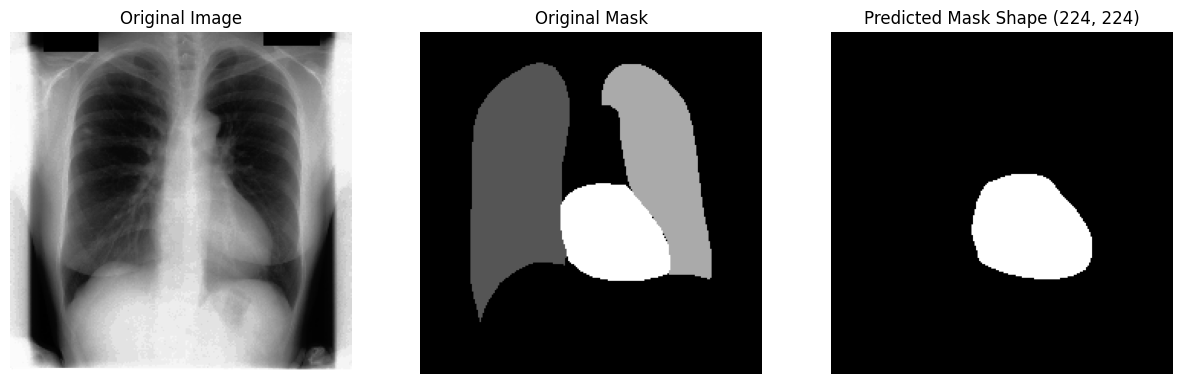

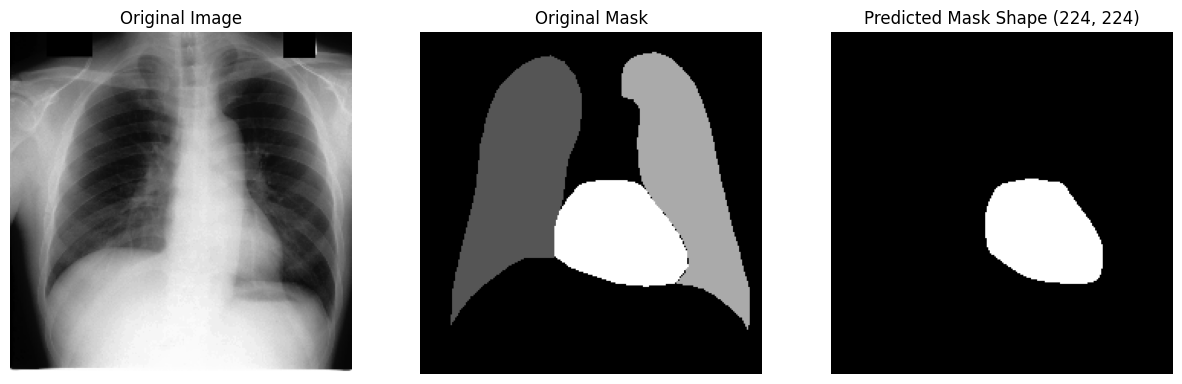

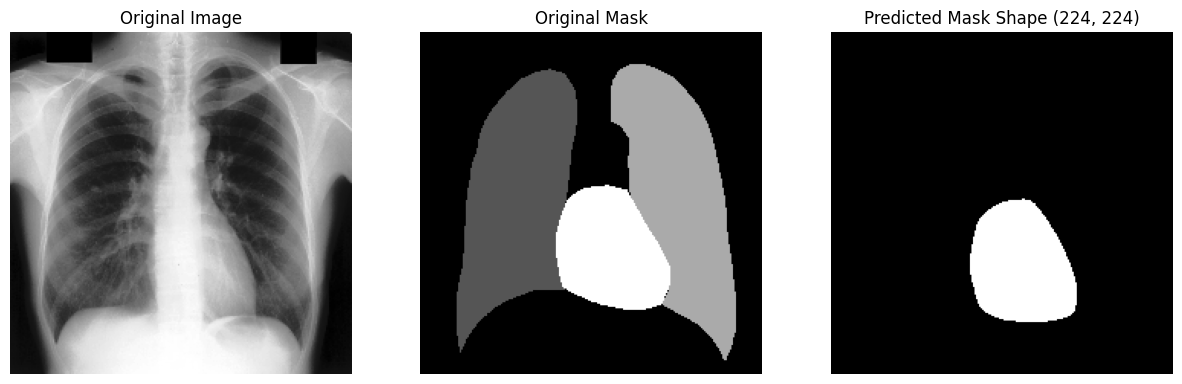

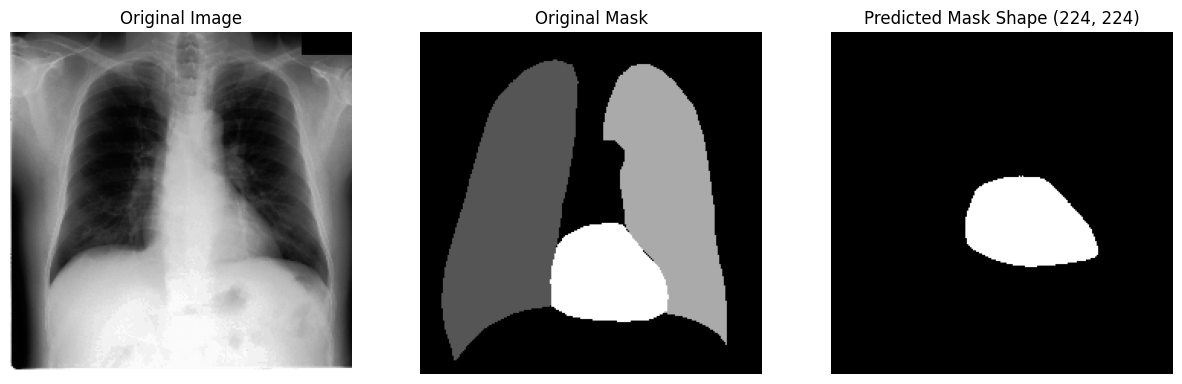

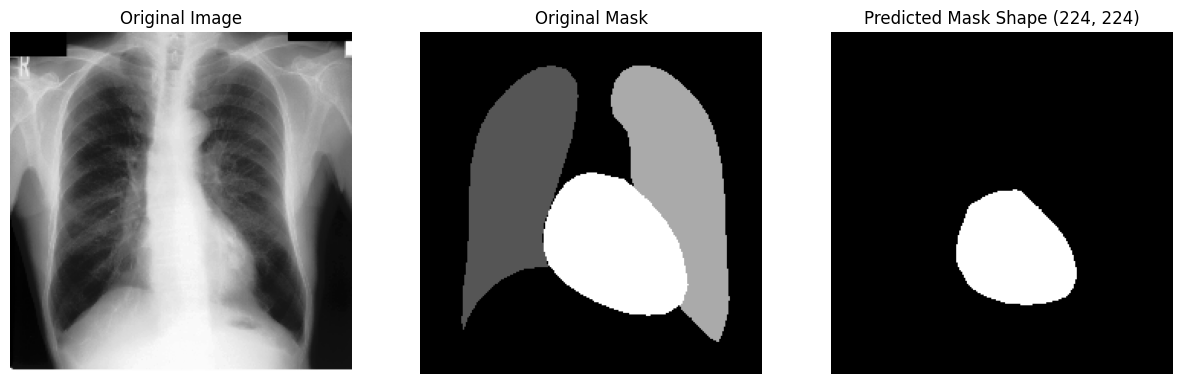

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Heart_Final.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device
)
visualize_predictions(original_images, original_masks, predicted_masks, k=5)

C:\Users\DryLab\AppData\Local\Temp\ipykernel_37880\1061647394.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./UNet_Lung.pth', map_location=dev

Loaded UNet model from this run.


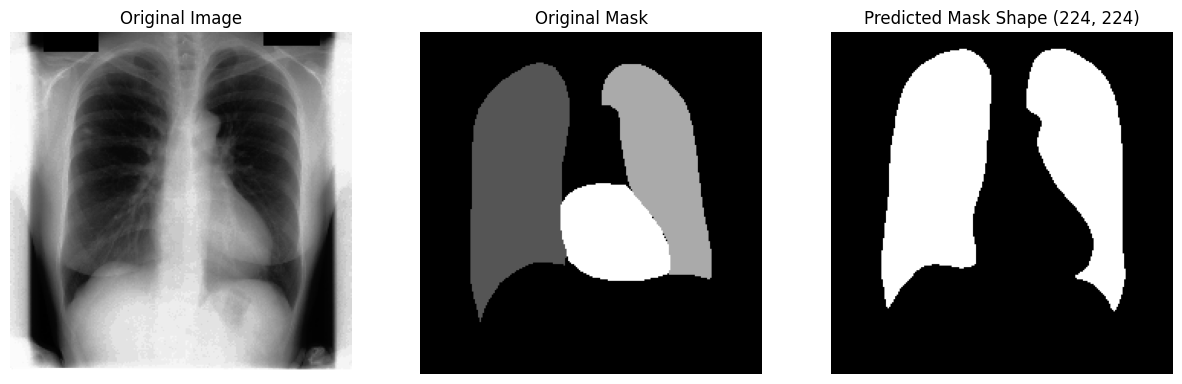

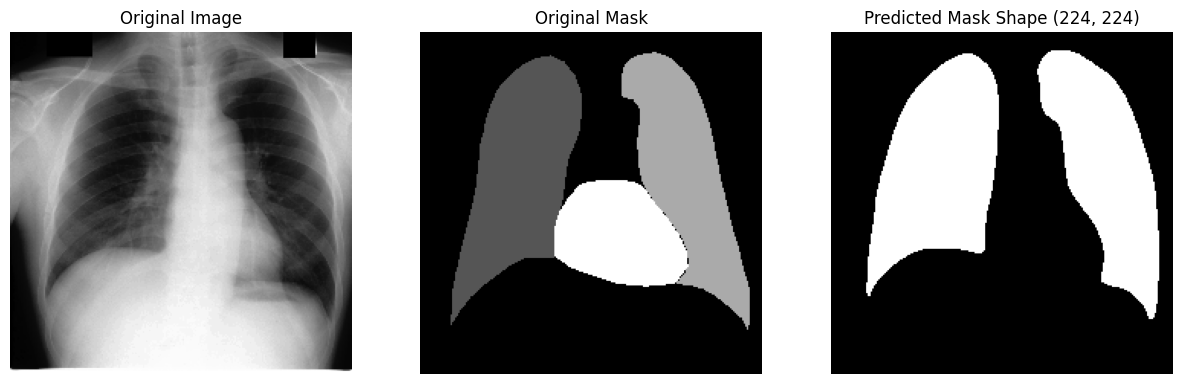

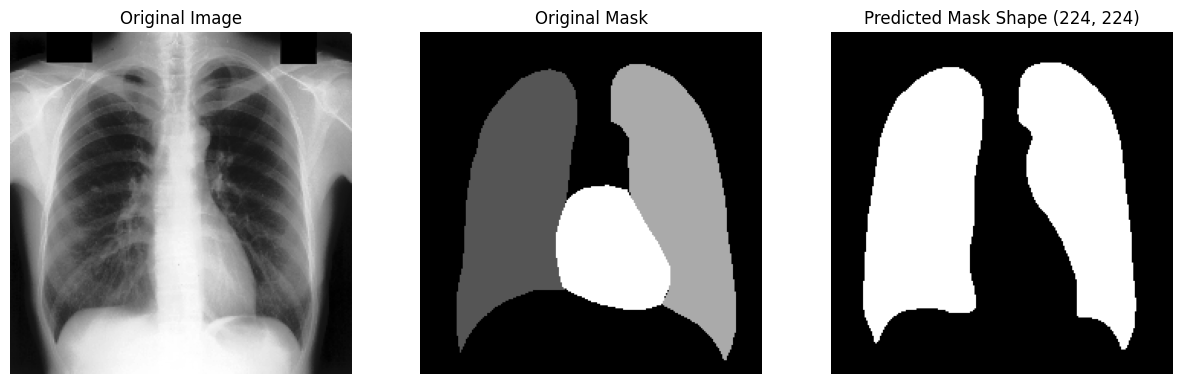

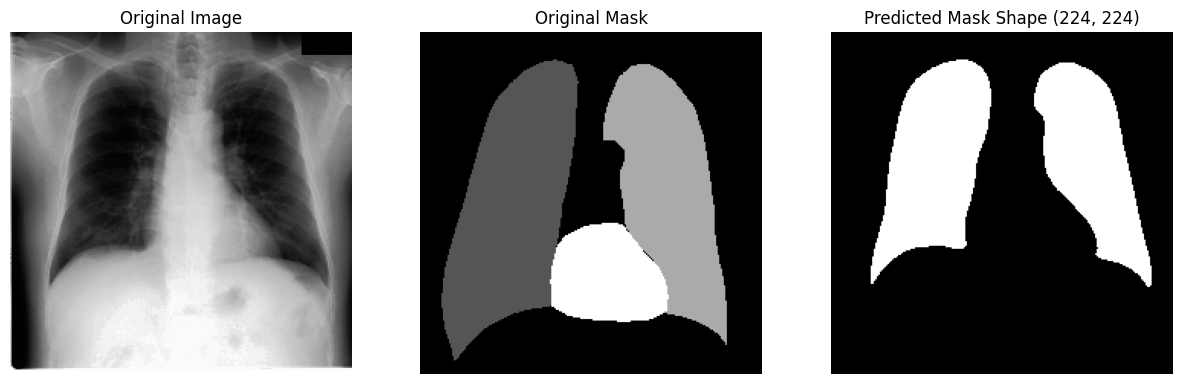

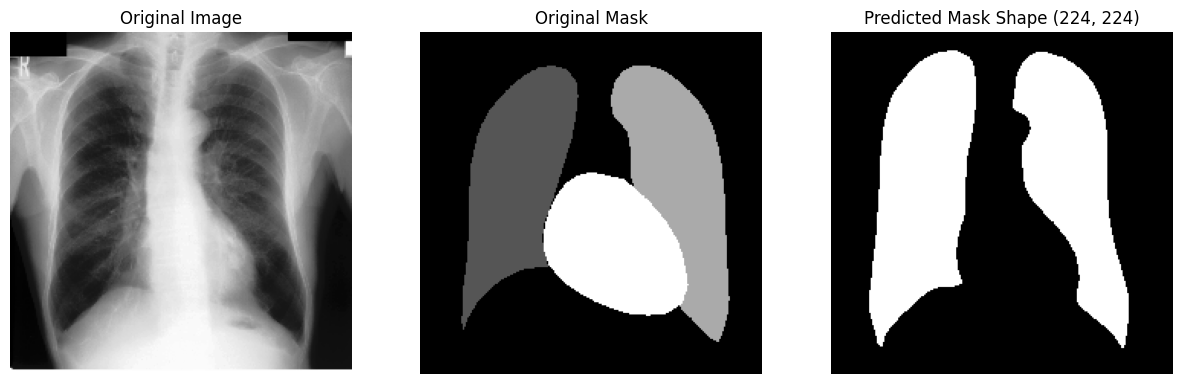

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Lung.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device
)
visualize_predictions(original_images, original_masks, predicted_masks, k=5)

# Multiclass Inference


In [22]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import binary_opening, binary_fill_holes, label, binary_dilation
from skimage.morphology import disk


def postprocess_mask(mask, num_classes):
    processed_masks = []

    for i in range(num_classes):
        class_mask = (mask == i).astype(np.uint8)  # Extract the mask for class 'i'

        # Apply binary opening with a disk structuring element of radius 5
        structuring_element = disk(5)
        opened_mask = binary_opening(class_mask, structure=structuring_element)

        # Label the connected components
        labeled_mask, num_features = label(opened_mask)

        # Find the largest connected component
        sizes = np.bincount(labeled_mask.ravel())
        if len(sizes) > 1:
            max_label = sizes[1:].argmax() + 1
            largest_segment = (labeled_mask == max_label).astype(np.uint8)

            # Fill holes in the largest connected component
            filled_mask = binary_fill_holes(largest_segment)

            # Apply binary dilation with the same structuring element
            final_mask = binary_dilation(filled_mask, structure=structuring_element)

            processed_masks.append(final_mask)
        else:
            processed_masks.append(np.zeros_like(class_mask))

    return np.stack(processed_masks, axis=0)


import torch


def test_model(model, test_loader, device, num_classes):
    model.eval()
    predicted_masks = []
    original_images = []
    original_masks = []
    with torch.inference_mode():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming the output is of shape (batch_size, num_classes, height, width)
            predicted_masks_batch = (
                outputs.argmax(dim=1).cpu().numpy()
            )  # Take the argmax across classes
            original_images.extend(images.cpu())
            original_masks.extend(masks.cpu())
            for mask in predicted_masks_batch:
                postprocessed_mask = postprocess_mask(mask, num_classes)
                predicted_masks.append(postprocessed_mask)
    return original_images, original_masks, predicted_masks


import matplotlib.pyplot as plt
import numpy as np


def visualize_predictions(images, original_masks, predicted_masks, k=5, num_classes=4):
    for i in range(min(k, len(images))):
        fig, axes = plt.subplots(1, num_classes + 2, figsize=(15, 5))

        # Display original image
        axes[0].imshow(images[i].permute(1, 2, 0).numpy(), cmap="gray")
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(original_masks[i][0], cmap="gray")

        axes[1].set_title("Original Mask")
        axes[1].axis("off")

        # Display predicted masks for each class
        for j in range(num_classes - 1):
            axes[j + 2].imshow(predicted_masks[i][j + 1], cmap="gray")
            axes[j + 2].set_title(f"Predicted Mask Class {j+1}")
            axes[j + 2].axis("off")

        # Plot whole predicted mask class
        axes[-1].imshow(predicted_masks[i].sum(axis=0), cmap="gray")

        plt.show()

C:\Users\DryLab\AppData\Local\Temp\ipykernel_37880\358782596.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('./UNet_Full.pth', map_location=devi

Loaded UNet model from this run.


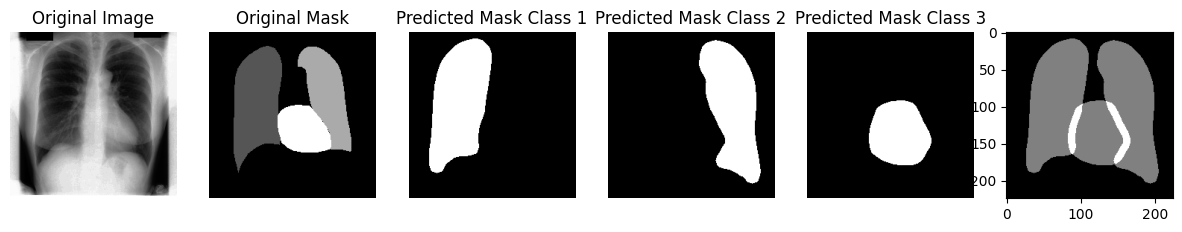

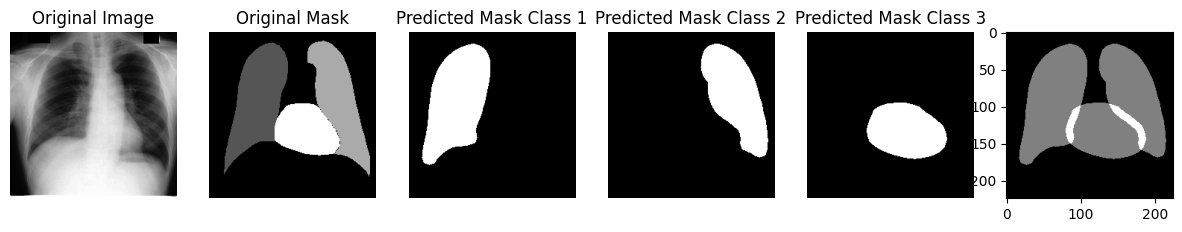

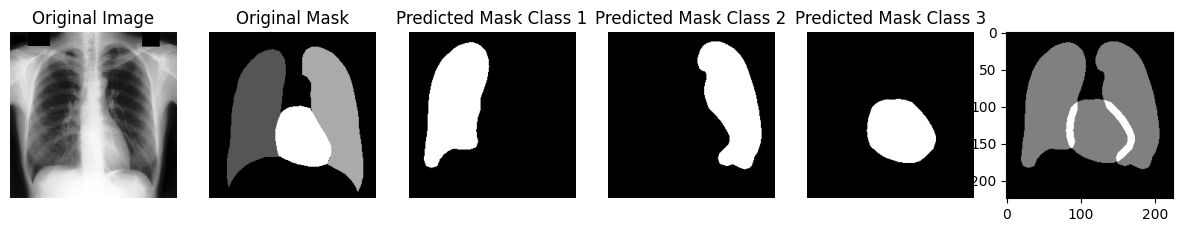

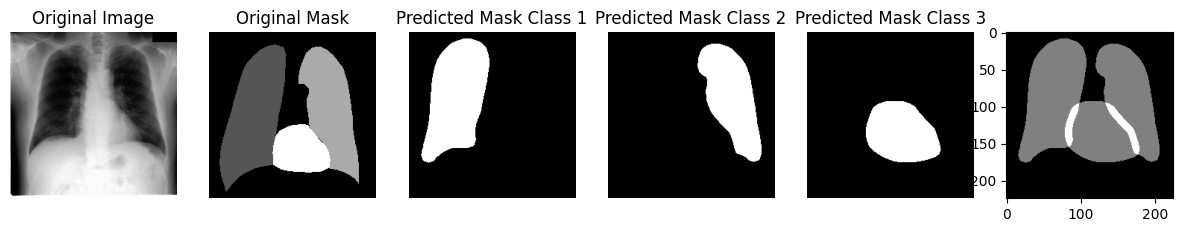

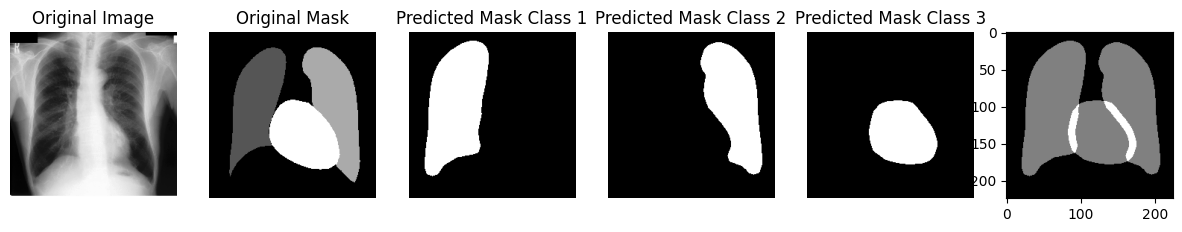

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

best_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded UNet model from this run.")

original_images, original_masks, predicted_masks = test_model(
    best_model, test_dataloader, device, num_classes=4
)
visualize_predictions(
    original_images, original_masks, predicted_masks, k=5, num_classes=4
)

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lung_model = torch.load("./UNet_Lung.pth", map_location=device)
print("Loaded Lungs UNet model from this run.")

heart_model = torch.load("./UNet_Heart_Final.pth", map_location=device)
print("Loaded Heart UNet model from this run.")

full_model = torch.load("./UNet_Full.pth", map_location=device)
print("Loaded Full UNet model from this run.")

C:\Users\DryLab\AppData\Local\Temp\ipykernel_31072\141638364.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lung_model = torch.load("./UNet_Lung.pth", map_location=devi

Loaded Lungs UNet model from this run.
Loaded Heart UNet model from this run.
Loaded Full UNet model from this run.


In [68]:
import torch


def generate_segmentation_mask(model, images):
    model.eval()
    with torch.inference_mode():
        images = images.to(device)
        outputs = model(images)
        # Assuming the output is of shape (batch_size, channels, height, width)
        # Taking the first channel
        predicted_masks = (outputs[:, 0, :, :] > 0.5).cpu().numpy()
    return predicted_masks


# Example image tensor (1, 1, 224, 224)
image = Image.open(
    "C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/physionet.org/files/mimic-cxr/2.0.0/p10/p10000764/s57375967/096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4.jpg"
).convert("L")
image = image.resize((224, 224), Image.NEAREST)
image = np.array(image)
image = image.astype(np.float32) / 255.0  # Normalize image to [0, 1]
image = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).to(device)

lung_mask = generate_segmentation_mask(lung_model, image)
heart_mask = generate_segmentation_mask(heart_model, image)

In [69]:
combined_mask = lung_mask | heart_mask

(-0.5, 223.5, 223.5, -0.5)

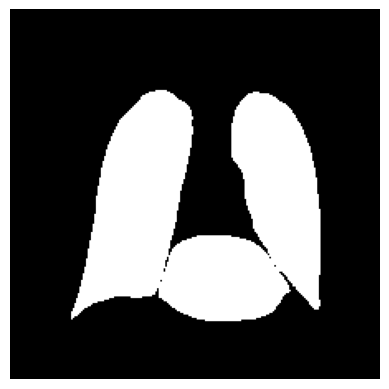

In [70]:
plt.imshow(combined_mask.squeeze(), cmap="gray")
plt.axis(False)

In [71]:
def generate_segmentation_mask(model, images):
    model.eval()
    with torch.inference_mode():
        images = images.to(device)
        outputs = model(images)
        # Assuming the output is of shape (batch_size, channels, height, width)
        # Taking the first channel
        predicted_masks = outputs.argmax(dim=1).cpu().numpy()
    return predicted_masks


full_mask = generate_segmentation_mask(full_model, image)

Left Lung Coordinates:
[[ 45  83]
 [ 45  84]
 [ 45  85]
 ...
 [175  27]
 [175  28]
 [175  29]]
Shape of left lung mask: torch.Size([1, 224, 224])
Right Lung Coordinates:
[[ 49 156]
 [ 49 157]
 [ 49 158]
 ...
 [187 202]
 [187 203]
 [187 204]]
Shape of right lung mask: torch.Size([1, 224, 224])
Heart Coordinates:
[[123 103]
 [123 104]
 [123 105]
 ...
 [181 139]
 [181 140]
 [181 141]]
Shape of heart mask: torch.Size([1, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

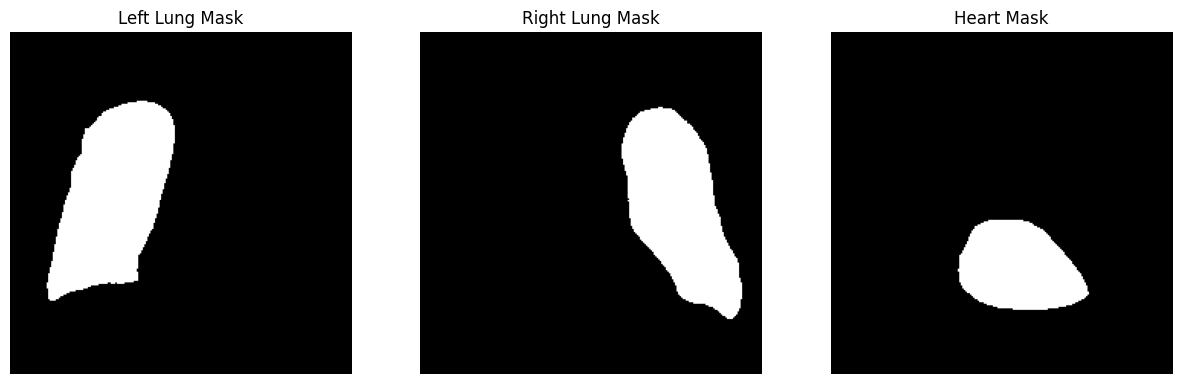

In [72]:
# Assume 'segmentation_output' is the output from your UNet model
# and has the shape (H, W) where each pixel value is the class label
# 0: background, 1: left lung, 2: right lung, 3: heart

# Get binary masks for each region
left_lung_mask = torch.from_numpy(full_mask) == 1
right_lung_mask = torch.from_numpy(full_mask) == 2
heart_mask = torch.from_numpy(full_mask) == 3

# Find the coordinates of each segmented region (ignoring the batch dimension)
left_lung_coords = torch.nonzero(left_lung_mask, as_tuple=False)[
    :, 1:
]  # Skip the batch index
right_lung_coords = torch.nonzero(right_lung_mask, as_tuple=False)[:, 1:]
heart_coords = torch.nonzero(heart_mask, as_tuple=False)[:, 1:]

# Convert to NumPy arrays (optional, for easier handling)
left_lung_coords = left_lung_coords.cpu().numpy()
right_lung_coords = right_lung_coords.cpu().numpy()
heart_coords = heart_coords.cpu().numpy()

# Print coordinates
print("Left Lung Coordinates:")
print(left_lung_coords)
print(f"Shape of left lung mask: {left_lung_mask.shape}")


print("Right Lung Coordinates:")
print(right_lung_coords)
print(f"Shape of right lung mask: {right_lung_mask.shape}")

print("Heart Coordinates:")
print(heart_coords)
print(f"Shape of heart mask: {heart_mask.shape}")

# Plotting the masks
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Left Lung Mask")
plt.imshow(left_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Right Lung Mask")
plt.imshow(right_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Heart Mask")
plt.imshow(heart_mask.squeeze(), cmap="gray")
plt.axis("off")


(-0.5, 223.5, 223.5, -0.5)

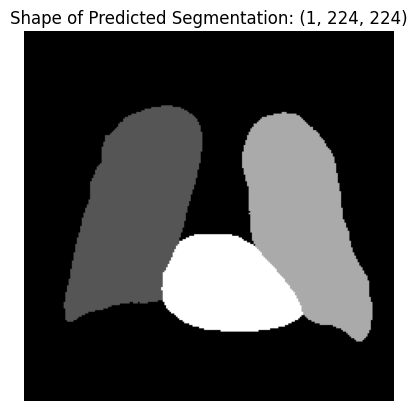

In [73]:
plt.imshow(full_mask.squeeze(), cmap="gray")
plt.title(f"Shape of Predicted Segmentation: {full_mask.shape}")
plt.axis(False)

### Generate Mask Coordinate for MIMIC-CXR Dataset


In [13]:
image_data_path = (
    "C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/physionet.org/files/mimic-cxr/2.0.0/p10"
)

In [14]:
def process_image_directory(image_dir):
    image_data = []

    # Traverse through all files in the image directory and its subdirectories
    for subdir, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith((".jpg")):
                image_path = os.path.join(subdir, file)
                image_data.append(
                    {
                        "parent_folder": os.path.basename(os.path.dirname(subdir)),
                        "subfolder": os.path.basename(subdir),
                        "image_name": os.path.join(
                            os.path.basename(os.path.dirname(subdir)),
                            os.path.join(os.path.basename(subdir), file),
                        ),
                        "image_path": image_path,
                    }
                )

    # Create DataFrame
    image_df = pd.DataFrame(image_data)
    return image_df

In [15]:
image_df = process_image_directory(image_data_path)

In [17]:
image_df

,parent_folder,subfolder,image_name,image_path
0,p10000032,s50414267,p10000032\s50414267\02aa804e-bde0afdd-112c0b34...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
1,p10000032,s50414267,p10000032\s50414267\174413ec-4ec4c1f7-34ea26b7...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
2,p10000032,s53189527,p10000032\s53189527\2a2277a9-b0ded155-c0de8eb9...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
3,p10000032,s53189527,p10000032\s53189527\e084de3b-be89b11e-20fe3f9f...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
4,p10000032,s53911762,p10000032\s53911762\68b5c4b1-227d0485-9cc38c3f...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
...,...,...,...,...
36544,p10999737,s52341872,p10999737\s52341872\5aea5877-40b40fee-5bccd163...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
36545,p10999737,s52341872,p10999737\s52341872\62973129-7b40a2cb-1e8778aa...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
36546,p10999737,s52341872,p10999737\s52341872\886bf7fe-d66084c6-5526a37b...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...
36547,p10999737,s56958909,p10999737\s56958909\23ca57bb-19b06ff8-ca4007f3...,C:/Users/DryLab/Desktop/ConVIRT/MIMIC-CXR/phys...


In [18]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    image_df, test_size=0.3, random_state=42, shuffle=True
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.6667, random_state=42, shuffle=True
)

print(
    f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}"
)

Train size: 25584, Validation size: 3654, Test size: 7311


(-0.5, 1023.5, 1023.5, -0.5)

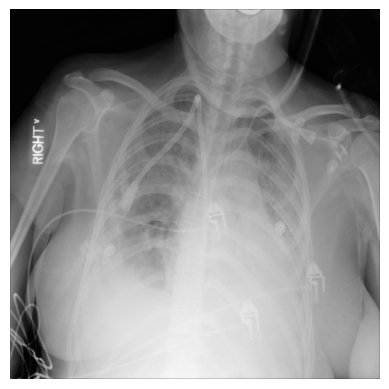

In [115]:
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_voi_lut

ds = dcmread("C:/Users/DryLab/Desktop/ConVIRT/rsna-pneumonia-detection-challenge/stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm")
plt.imshow(ds.pixel_array, cmap='gray')
plt.axis(False)

In [116]:
data_voi = apply_voi_lut(ds.pixel_array, ds)
data_voi

array([[  1,   1,   2, ...,   2,   1,   0],
       [  2,   2,   2, ...,   4,   3,   2],
       [  2,   3,   3, ...,   5,   4,   3],
       ...,
       [ 52,  80,  62, ..., 140, 143,  80],
       [ 60,  88,  72, ..., 136, 138,  84],
       [ 27,  49,  37, ...,  64,  75,  36]], dtype=uint8)

In [117]:
data = ds.pixel_array
data

array([[  1,   1,   2, ...,   2,   1,   0],
       [  2,   2,   2, ...,   4,   3,   2],
       [  2,   3,   3, ...,   5,   4,   3],
       ...,
       [ 52,  80,  62, ..., 140, 143,  80],
       [ 60,  88,  72, ..., 136, 138,  84],
       [ 27,  49,  37, ...,  64,  75,  36]], dtype=uint8)

In [118]:
ds.PhotometricInterpretation

'MONOCHROME2'

In [119]:
data_voi = data_voi - np.min(data_voi)
data_voi = data_voi / np.max(data_voi)
data_voi = (data_voi * 255).astype(np.uint8)
data_voi

array([[  1,   1,   2, ...,   2,   1,   0],
       [  2,   2,   2, ...,   4,   3,   2],
       [  2,   3,   3, ...,   6,   4,   3],
       ...,
       [ 63,  97,  75, ..., 170, 174,  97],
       [ 73, 107,  87, ..., 165, 168, 102],
       [ 32,  59,  45, ...,  78,  91,  43]], dtype=uint8)

In [120]:
data_voi = np.array(data_voi)
data_voi

array([[  1,   1,   2, ...,   2,   1,   0],
       [  2,   2,   2, ...,   4,   3,   2],
       [  2,   3,   3, ...,   6,   4,   3],
       ...,
       [ 63,  97,  75, ..., 170, 174,  97],
       [ 73, 107,  87, ..., 165, 168, 102],
       [ 32,  59,  45, ...,  78,  91,  43]], dtype=uint8)

In [122]:
data_voi = cv2.resize(data_voi, (224, 224), interpolation=cv2.INTER_NEAREST)
data_voi = data_voi.astype(np.float32) / 255.0  # Normalize data_voi to [0, 1]
data_voi = torch.from_numpy(data_voi).unsqueeze(0).unsqueeze(0).to(device)

In [124]:
full_mask = generate_segmentation_mask(full_model, data_voi)

Left Lung Coordinates:
[[ 37 106]
 [ 37 107]
 [ 37 108]
 ...
 [176  35]
 [176  36]
 [176  37]]
Shape of left lung mask: torch.Size([1, 224, 224])
Right Lung Coordinates:
[[ 46 156]
 [ 46 157]
 [ 47 154]
 ...
 [211 190]
 [211 191]
 [211 192]]
Shape of right lung mask: torch.Size([1, 224, 224])
Heart Coordinates:
[[116 125]
 [116 126]
 [116 127]
 ...
 [180 159]
 [180 160]
 [180 161]]
Shape of heart mask: torch.Size([1, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

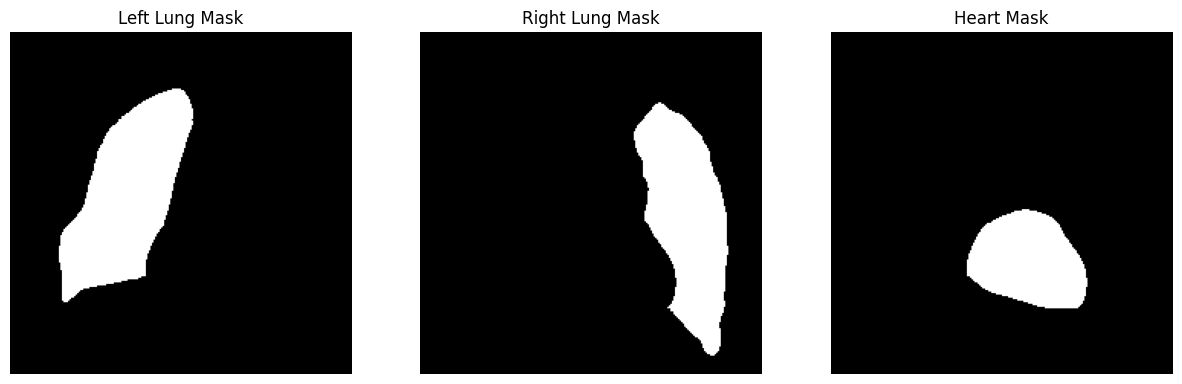

In [125]:
# Assume 'segmentation_output' is the output from your UNet model
# and has the shape (H, W) where each pixel value is the class label
# 0: background, 1: left lung, 2: right lung, 3: heart

# Get binary masks for each region
left_lung_mask = torch.from_numpy(full_mask) == 1
right_lung_mask = torch.from_numpy(full_mask) == 2
heart_mask = torch.from_numpy(full_mask) == 3

# Find the coordinates of each segmented region (ignoring the batch dimension)
left_lung_coords = torch.nonzero(left_lung_mask, as_tuple=False)[
    :, 1:
]  # Skip the batch index
right_lung_coords = torch.nonzero(right_lung_mask, as_tuple=False)[:, 1:]
heart_coords = torch.nonzero(heart_mask, as_tuple=False)[:, 1:]

# Convert to NumPy arrays (optional, for easier handling)
left_lung_coords = left_lung_coords.cpu().numpy()
right_lung_coords = right_lung_coords.cpu().numpy()
heart_coords = heart_coords.cpu().numpy()

# Print coordinates
print("Left Lung Coordinates:")
print(left_lung_coords)
print(f"Shape of left lung mask: {left_lung_mask.shape}")


print("Right Lung Coordinates:")
print(right_lung_coords)
print(f"Shape of right lung mask: {right_lung_mask.shape}")

print("Heart Coordinates:")
print(heart_coords)
print(f"Shape of heart mask: {heart_mask.shape}")

# Plotting the masks
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Left Lung Mask")
plt.imshow(left_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Right Lung Mask")
plt.imshow(right_lung_mask.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Heart Mask")
plt.imshow(heart_mask.squeeze(), cmap="gray")
plt.axis("off")


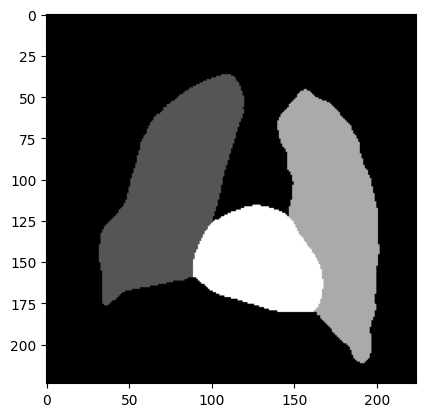

In [126]:
plt.imshow(full_mask.squeeze(), cmap="gray") 

In [57]:
import pydicom
import os

# Define the path to your data folder
data_folder = "C:/Users/DryLab/Desktop/ConVIRT/rsna-pneumonia-detection-challenge/stage_2_train_images"

# Set to store unique subfolder names
printed_subfolders = set()
count = 0
# Traverse through folders to look for PA in ViewPosition DICOM tag
for files in os.listdir(data_folder):
    # Read the DICOM file
    ds = pydicom.dcmread(os.path.join(data_folder, files))

    # Check if the ViewPosition tag is present
    if hasattr(ds, "ViewPosition"):
        # Check if the ViewPosition is PA
        if ds.ViewPosition == "PA":
            # Extract the subfolder name
            count += 1
            
print(f"Total number of PA images: {count}")

Total number of PA images: 14511


In [ ]:
image_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/preprocessed_xray"
mask_dir = "C:/Users/DryLab/Desktop/ViLLA/RPN_MIMIC/All247imagesPNG/masks"

# Get list of image and mask files
image_paths = sorted(
    [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
)
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Split data into train, validation, and test sets into 0.8, 0.1, 0.1
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = (
    train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)
)
val_image_paths, test_image_paths, val_mask_paths, test_mask_paths = train_test_split(
    test_image_paths, test_mask_paths, test_size=0.5, random_state=42
)

# Create dataset
train_heart_dataset = CustomDataset(
    train_image_paths, train_mask_paths, transform=transform
)
val_heart_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=None)
test_heart_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=None)

# Create dataloader
train_dataloader = DataLoader(train_heart_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_heart_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_heart_dataset, batch_size=16, shuffle=False)